In [488]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from dataset import BrightfieldMicroscopyDataset

from scipy.fft import fft2, ifft2, fftshift, ifftshift

from torch.utils.data import DataLoader

from tqdm import tqdm
import random

In [454]:
train_set = BrightfieldMicroscopyDataset()

In [455]:
image, label = train_set[100]

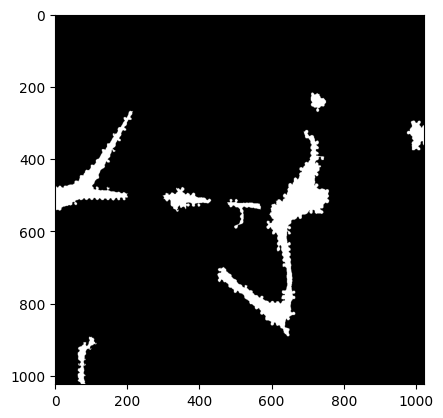

In [456]:
plt.imshow(label, cmap='gray')

In [457]:
def remove_repeating_pattern(input_image, threshold=0.1, iterations=1):
    """
    Removes repeating patterns from an image using FFT.
    
    Parameters:
    - image: 2D numpy array, the input image.
    - threshold: float, threshold for identifying peaks in the frequency domain.
    - iterations: int, number of iterations to refine the pattern removal.

    Returns:
    - cleaned_image: 2D numpy array, the image with the pattern removed.
    """
    image = input_image.copy()
    for _ in range(iterations):
        # Step 1: FFT to frequency domain
        f = fft2(image)
        fshift = fftshift(f)
        magnitude = np.abs(fshift)

        # Step 2: Identify pattern frequencies
        mask = magnitude > (threshold * np.max(magnitude))
        pattern_fshift = fshift * mask

        # Step 3: Reconstruct pattern using inverse FFT
        pattern = np.real(ifft2(ifftshift(pattern_fshift)))

        # Step 4: Subtract pattern from original image
        image = image - pattern

    return image

In [451]:
def visualize_data(image, label, channels_to_plot=None):
    """
    Visualizes the original image, FFT spectrum, and filtered image for each channel.
    
    Parameters:
    - image: numpy array of shape (channels, height, width), the input image stack.
    """
    channels = image.shape[0]
    plt.figure(figsize=(15, channels * 5))  # Adjust figure size for better visualization

    if channels_to_plot is None:
        channels_to_plot = channels

    summed_image = np.zeros(image.shape[1:])

    image = image.numpy()

    for i in range(channels_to_plot):
        # Plot the channel image
        plt.subplot(channels, 7, 7 * i + 1)  # Column 1: Original image
        plt.imshow(image[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Channel {i + 1}")
        
        # Compute the FFT spectrum
        f = np.fft.fft2(image[i])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log(np.abs(fshift) + 1)  # Log scale for better visualization

        # Plot the FFT spectrum
        plt.subplot(channels, 7, 7 * i + 2)  # Column 2: FFT spectrum
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.axis('off')
        plt.title(f"FFT Spectrum {i + 1}")

        # Remove repeating pattern
        cleaned_image = remove_repeating_pattern(image[i], threshold=0.01, iterations=2)

        # Plot the cleaned image
        plt.subplot(channels, 7, 7 * i + 3)  # Column 3: Filtered image
        plt.imshow(cleaned_image, cmap='gray')
        plt.axis('off')
        plt.title(f"Filtered Image {i + 1}")

        tensor_min = cleaned_image.min()
        tensor_max = cleaned_image.max()
        normalized_tensor = (cleaned_image - tensor_min) / (tensor_max - tensor_min) * 255

        edged = cv2.Canny(normalized_tensor, 70, 80)

        plt.subplot(channels, 7, 7 * i + 4)  # Column 3: Filtered image
        plt.imshow(edged, cmap='gray')
        plt.axis('off')
        plt.title(f"Canny edges {i + 1}")


        # opened = cv2.morphologyEx(edged, cv2.MORPH_OPEN, kernel)
        diation_kernel = np.ones((3,3),np.uint8)
        dilated = cv2.dilate(edged,diation_kernel,iterations = 1)

        plt.subplot(channels, 7, 7 * i + 5)  # Column 3: Filtered image
        plt.imshow(dilated, cmap='gray')
        plt.axis('off')
        plt.title(f"Dilated {i + 1}")

        # ret,thresh1 = cv2.threshold(dilated,200,255,cv2.THRESH_BINARY)
        closing_kernel = np.ones((3,3),np.uint8)
        closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, closing_kernel)

        plt.subplot(channels, 7, 7 * i + 6)  # Column 3: Filtered image
        plt.imshow(closing, cmap='gray')
        plt.axis('off')
        plt.title(f"Label mask {i + 1}")

        plt.subplot(channels, 7, 7 * i + 7)  # Column 3: Filtered image
        plt.imshow(label, cmap='gray')
        plt.axis('off')
        plt.title(f"Label mask {i + 1}")

        summed_image += dilated

    plt.tight_layout()
    plt.show()

    return summed_image

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'Canny'


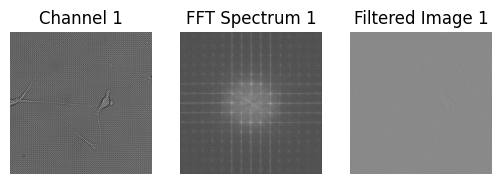

In [452]:
channels_to_use = 11

cumulated_image = visualize_data(image, label, channels_to_plot=channels_to_use)

In [ ]:
preprocessed_image = cumulated_image.copy()

In [ ]:
preprocessed_image

array([[2550., 2805., 2550., ..., 2550., 1785., 1785.],
       [2550., 2805., 2805., ..., 2550., 2040., 2040.],
       [2805., 2805., 2805., ..., 2040., 2040., 2040.],
       ...,
       [2040., 2295., 2295., ..., 2805., 2805., 2805.],
       [2040., 2295., 2550., ..., 2805., 2805., 2805.],
       [2040., 2295., 2040., ..., 2805., 2805., 2805.]])

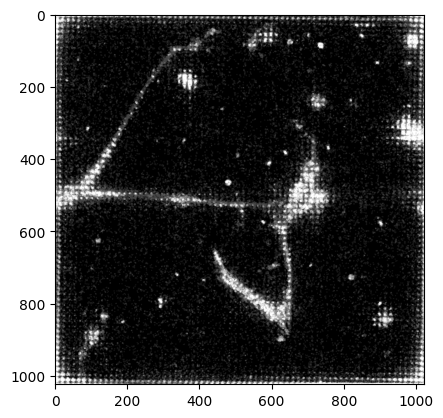

In [ ]:
plt.imshow(preprocessed_image, cmap='gray')

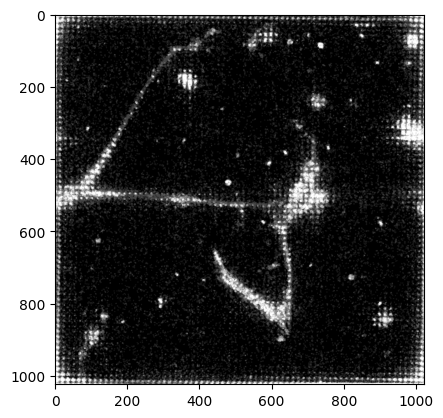

In [ ]:
preprocessed_image_avg = preprocessed_image / channels_to_use

plt.imshow(preprocessed_image_avg, cmap='gray')

In [ ]:
preprocessed_image_avg

array([[231.81818182, 255.        , 231.81818182, ..., 231.81818182,
        162.27272727, 162.27272727],
       [231.81818182, 255.        , 255.        , ..., 231.81818182,
        185.45454545, 185.45454545],
       [255.        , 255.        , 255.        , ..., 185.45454545,
        185.45454545, 185.45454545],
       ...,
       [185.45454545, 208.63636364, 208.63636364, ..., 255.        ,
        255.        , 255.        ],
       [185.45454545, 208.63636364, 231.81818182, ..., 255.        ,
        255.        , 255.        ],
       [185.45454545, 208.63636364, 185.45454545, ..., 255.        ,
        255.        , 255.        ]])

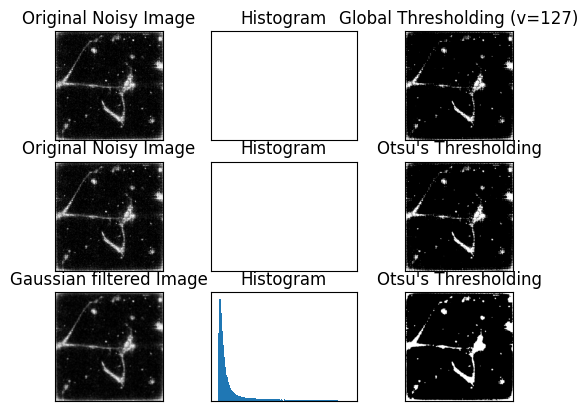

In [ ]:
img = cv2.convertScaleAbs(preprocessed_image_avg)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
 
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(11,11),5)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
 
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

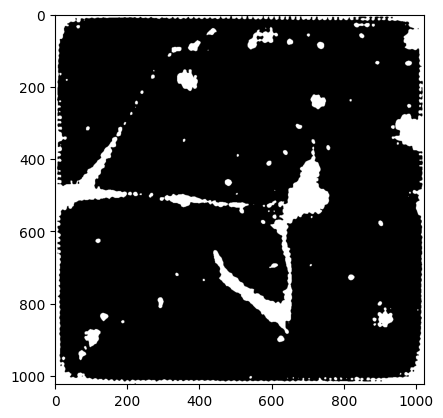

In [ ]:
plt.imshow(th3, 'gray')

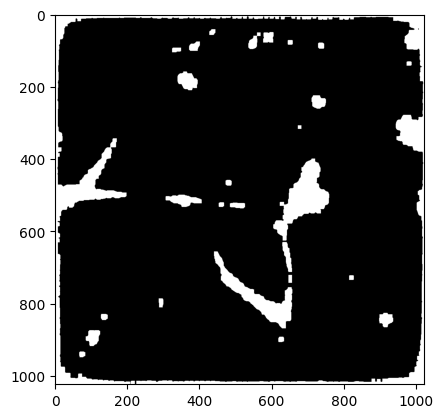

In [ ]:
kernel = np.ones((10,10),np.uint8)
opening_img = th3.copy()
opening = cv2.morphologyEx(opening_img, cv2.MORPH_OPEN, kernel)

plt.imshow(opening, 'gray')

In [ ]:
crop_width = 15

cropped = opening.copy()

cropped[:crop_width, :] = 0
cropped[-crop_width:, :] = 0
cropped[:, :crop_width] = 0
cropped[:, -crop_width:] = 0 

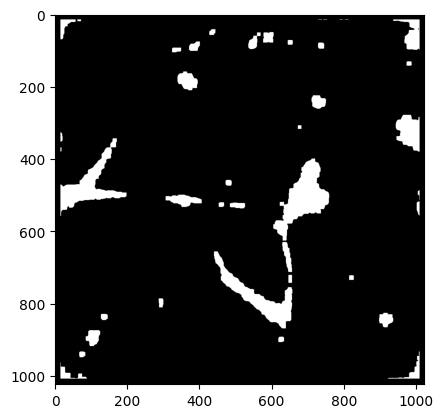

In [ ]:
plt.imshow(cropped, 'gray')

In [ ]:
corner_width = 100  # Width of the rectangular corner area
corner_height = 100  # Height of the rectangular corner area

# Set rectangular corner areas to black
# Top-left corner
cropped[:corner_height, :corner_width] = 0
# Top-right corner
cropped[:corner_height, -corner_width:] = 0
# Bottom-left corner
cropped[-corner_height:, :corner_width] = 0
# Bottom-right corner
cropped[-corner_height:, -corner_width:] = 0

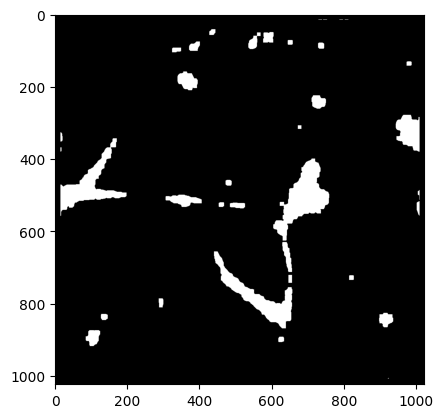

In [ ]:
plt.imshow(cropped, 'gray')

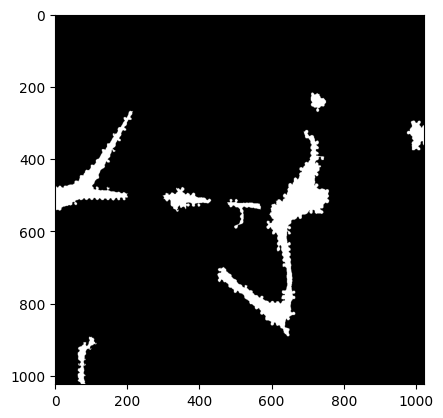

In [ ]:
plt.imshow(label, 'gray')

In [ ]:
accuracy = np.sum(label.numpy() == cropped) / label.numpy().size

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.77%


In [458]:
def calculate_segmentation_metrics(predicted_mask, label_mask):
    """
    Calculate segmentation performance metrics.
    
    Args:
        predicted_mask (numpy.ndarray): Predicted binary segmentation mask
        label_mask (numpy.ndarray): Ground truth binary segmentation mask
    
    Returns:
        dict: Segmentation performance metrics
    """
    # Ensure masks are binary (0 or 1)
    predicted_mask = (predicted_mask > 0).astype(np.uint8)
    label_mask = (label_mask > 0).astype(np.uint8)
    
    # Pixel Accuracy: Proportion of correctly classified pixels
    pixel_accuracy = np.sum(predicted_mask == label_mask) / label_mask.size
    
    # Intersection over Union (IoU)
    intersection = np.logical_and(predicted_mask, label_mask)
    union = np.logical_or(predicted_mask, label_mask)
    iou = np.sum(intersection) / np.sum(union)
    
    # Dice Coefficient (F1 Score)
    dice_coefficient = 2 * np.sum(intersection) / (np.sum(predicted_mask) + np.sum(label_mask))
    
    # Precision: Proportion of predicted positives that are actually positive
    true_positives = np.sum(np.logical_and(predicted_mask, label_mask))
    predicted_positives = np.sum(predicted_mask)
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    
    # Recall: Proportion of actual positives that are correctly predicted
    actual_positives = np.sum(label_mask)
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    
    return {
        'pixel_accuracy': pixel_accuracy,
        'iou': iou,
        'dice_coefficient': dice_coefficient,
        'precision': precision,
        'recall': recall
    }

In [480]:
def fft_segmentation(image, label, channels_to_calculate=None):
    """
    Perform image segmentation using FFT and computer vision techniques.
    
    Args:
        image (torch.Tensor): Input image tensor
        label (torch.Tensor): Ground truth label tensor
        channels_to_calculate (int, optional): Number of channels to process
    
    Returns:
        tuple: Processed image, original label, segmentation accuracy
    """

    # Convert image to NumPy if it's a tensor
    image_np = image.numpy()
    
    # Determine number of channels to process
    channels = image_np.shape[0]
    channels_to_use = channels_to_calculate or channels
    
    # Initialize summed image
    summed_image = np.zeros(image_np.shape[1:], dtype=np.float32)
    
    # Visualization figure (optional)
    plt.figure(figsize=(15, channels_to_use * 5))
    
    # Process each channel
    for i in range(channels_to_use):
        # Remove repeating patterns
        cleaned_image = remove_repeating_pattern(image_np[i])
        
        # Normalize image
        tensor_min, tensor_max = cleaned_image.min(), cleaned_image.max()
        normalized_tensor = (cleaned_image - tensor_min) / (tensor_max - tensor_min) * 255
        
        # Convert to uint8 for OpenCV processing
        image_uint8 = normalized_tensor.astype(np.uint8)
        
        # Edge detection
        edged = cv2.Canny(image_uint8, 70, 80)
        
        # Dilation to connect edges
        dilation_kernel = np.ones((3,3), np.uint8)
        dilated = cv2.dilate(edged, dilation_kernel, iterations=1)
        
        # Accumulate processed channels
        summed_image += dilated
    
    # Average the processed channels
    img_avg = summed_image / channels_to_use
    img = cv2.convertScaleAbs(img_avg)
    
    # Apply Gaussian blur and Otsu's thresholding
    blur = cv2.GaussianBlur(img, (11, 11), 5)
    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Morphological opening
    kernel = np.ones((10, 10), np.uint8)
    opening = cv2.morphologyEx(th3.copy(), cv2.MORPH_OPEN, kernel)
    
    # Crop and clean the image
    crop_width = 15
    corner_width = 100
    corner_height = 100
    
    cropped = opening.copy()
    
    # Remove border regions
    cropped[:crop_width, :] = 0
    cropped[-crop_width:, :] = 0
    cropped[:, :crop_width] = 0
    cropped[:, -crop_width:] = 0
    
    # Remove corner regions
    cropped[:corner_height, :corner_width] = 0
    cropped[:corner_height, -corner_width:] = 0
    cropped[-corner_height:, :corner_width] = 0
    cropped[-corner_height:, -corner_width:] = 0
    
    metrics = calculate_segmentation_metrics(cropped, label.numpy())
    
    return cropped, label, metrics

In [485]:
image, label = train_set[500]

predicted, label, metrics = fft_segmentation(image, label)

<Figure size 1500x5500 with 0 Axes>

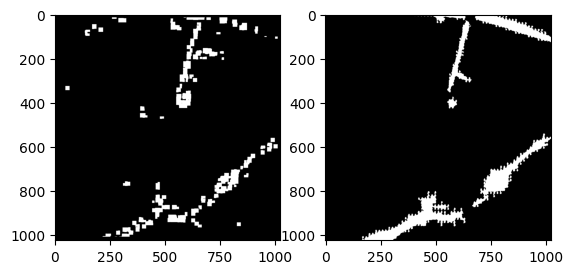

In [486]:
plt.subplot(1,2,1)
plt.imshow(predicted, 'gray')
plt.subplot(1,2,2)
plt.imshow(label, 'gray')

In [487]:
print("Segmentation Metrics:")
for metric, value in metrics.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Segmentation Metrics:
Pixel Accuracy: 0.9409
Iou: 0.3510
Dice Coefficient: 0.5196
Precision: 0.6218
Recall: 0.4463


In [474]:
train_dataloader = DataLoader(train_set, batch_size=1, shuffle=False)

In [483]:
def perform_segmentation_evaluation(dataloader, print_interval=20):
    all_metrics = {
        'pixel_accuracy': [],
        'iou': [],
        'dice_coefficient': [],
        'precision': [],
        'recall': []
    }

    # Iterate through the dataloader
    for idx, (image, label) in enumerate(tqdm(dataloader, desc="Segmentation Evaluation"), 1):
        image = image[0]
        label = label[0]
        
        # Perform segmentation based on the chosen method
        predicted_mask, _, _ = fft_segmentation(image, label)
        
        # Calculate metrics for this batch
        batch_metrics = calculate_segmentation_metrics(predicted_mask, label.numpy())
        
        # Store metrics
        for metric_name, metric_value in batch_metrics.items():
            all_metrics[metric_name].append(metric_value)
        
        # Print intermediate metrics at specified interval
        if idx % print_interval == 0:
            print(f"\nIntermediate Metrics at Image {idx}:")
            current_aggregated_metrics = {
                metric_name: np.mean(metric_values)
                for metric_name, metric_values in all_metrics.items()
            }
            
            for metric_name, metric_value in current_aggregated_metrics.items():
                print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
    
    # Calculate final average metrics
    aggregated_metrics = {
        metric_name: np.mean(metric_values)
        for metric_name, metric_values in all_metrics.items()
    }
    
    # Calculate metric variance for additional insight
    metric_variance = {
        metric_name: np.var(metric_values)
        for metric_name, metric_values in all_metrics.items()
    }
    
    # Print final detailed results
    print("\nFinal Segmentation Metrics Summary:")
    for metric_name, metric_value in aggregated_metrics.items():
        print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
    
    print("\nFinal Metric Variance:")
    for metric_name, variance in metric_variance.items():
        print(f"{metric_name.replace('_', ' ').title()} Variance: {variance:.6f}")
    
    return {
        'mean_metrics': aggregated_metrics,
        'metric_variance': metric_variance,
        'per_batch_metrics': all_metrics
    }

In [489]:
def visualize_segmentation(dataset, segmentation_function, n_samples=5):
    # Draw n random indices from the dataset
    indices = random.sample(range(len(dataset)), n_samples)

    for i, idx in enumerate(indices):
        # Get the image and label pair
        image, label = dataset[idx]

        # Perform segmentation
        predicted, label, metrics = segmentation_function(image, label)

        # Plot the predicted mask and ground truth
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Predicted Mask")
        plt.imshow(predicted, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.suptitle(f"Sample {i + 1}")
        plt.show()

        # Print segmentation metrics
        print("Segmentation Metrics for Sample", i + 1)
        for metric, value in metrics.items():
            print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")
        print("-" * 30)

In [ ]:
visualize_segmentation(train_set, fft_segmentation, n_samples=5)